#### imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn
from torch import optim
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

import scipy.io as io
import os
import json

#### transforms

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    normalize]),
                                                            
    'other' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])
}

#### downloads

In [3]:
if not os.path.exists('./data'):
    train_dataset = torchvision.datasets.Flowers102(root='data/train', download=True, transform=data_transforms['training'])
    other_dataset = torchvision.datasets.Flowers102(root='data/other', download=True, transform=data_transforms['other'])

#### .mat loading

In [4]:
image_labels_mat = io.loadmat('data/train/flowers-102/imagelabels.mat')
image_labels = image_labels_mat['labels'][0]

set_id_mat = io.loadmat('data/train/flowers-102/setid.mat')
train_id = set_id_mat['trnid'][0]
test_id = set_id_mat['tstid'][0]
val_id = set_id_mat['valid'][0]

#### formatting

In [5]:
directory_train = sorted(os.listdir("data/train/flowers-102/jpg"))
directory_other = sorted(os.listdir("data/other/flowers-102/jpg"))

In [6]:
image_names_train = [f"image_0{str(x).rjust(4,'0')}.jpg" for x in sorted(train_id)]
image_names_test = [f"image_0{str(x).rjust(4,'0')}.jpg" for x in sorted(test_id)]
image_names_val = [f"image_0{str(x).rjust(4,'0')}.jpg" for x in sorted(val_id)]

#### directory manipulating

In [7]:
if not os.path.exists('./content'):
    for i in range(len(directory_train)):
        directory_label = str(image_labels[i]).rjust(4, '0')
        if directory_train[i] in image_names_train:
            if not os.path.exists(f"content/train/flowers-102/{directory_label}"):
                os.makedirs(f"content/train/flowers-102/{directory_label}")
            os.rename(f"data/train/flowers-102/jpg/{directory_train[i]}", f"content/train/flowers-102/{directory_label}/{directory_train[i]}")

    for i in range(len(directory_other)):
        directory_label = str(image_labels[i]).rjust(4, '0')
        if directory_other[i] in image_names_test:
            if not os.path.exists(f"content/test/flowers-102/{directory_label}"):
                os.makedirs(f"content/test/flowers-102/{directory_label}")
            os.rename(f"data/other/flowers-102/jpg/{directory_other[i]}", f"content/test/flowers-102/{directory_label}/{directory_other[i]}")
        
        elif directory_other[i] in image_names_val:
            if not os.path.exists(f"content/val/flowers-102/{directory_label}"):
                os.makedirs(f"content/val/flowers-102/{directory_label}")
            os.rename(f"data/other/flowers-102/jpg/{directory_other[i]}", f"content/val/flowers-102/{directory_label}/{directory_other[i]}")

#### Define datasets

In [8]:
train_data = torchvision.datasets.ImageFolder(root='content/train/flowers-102', transform=data_transforms['training'])
test_data = torchvision.datasets.ImageFolder(root='content/test/flowers-102', transform=data_transforms['other'])
val_data = torchvision.datasets.ImageFolder(root='content/val/flowers-102', transform=data_transforms['other'])

#### Loading the dataset

In [9]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

#### classes

In [10]:
if not os.path.exists('flower_to_name.json'):
  classes = {
           "21": "fire lily",
           "3": "canterbury bells",
           "45": "bolero deep blue",
           "1": "pink primrose",
           "34": "mexican aster",
           "27": "prince of wales feathers",
           "7": "moon orchid",
           "16": "globe-flower",
           "25": "grape hyacinth",
           "26": "corn poppy",
           "79": "toad lily",
           "39": "siam tulip",
           "24": "red ginger",
           "67": "spring crocus",
           "35": "alpine sea holly",
           "32": "garden phlox",
           "10": "globe thistle",
           "6": "tiger lily",
           "93": "ball moss",
           "33": "love in the mist",
           "9": "monkshood",
           "102": "blackberry lily",
           "14": "spear thistle",
           "19": "balloon flower",
           "100": "blanket flower",
           "13": "king protea",
           "49": "oxeye daisy",
           "15": "yellow iris",
           "61": "cautleya spicata",
           "31": "carnation",
           "64": "silverbush",
           "68": "bearded iris",
           "63": "black-eyed susan",
           "69": "windflower",
           "62": "japanese anemone",
           "20": "giant white arum lily",
           "38": "great masterwort",
           "4": "sweet pea",
           "86": "tree mallow",
           "101": "trumpet creeper",
           "42": "daffodil",
           "22": "pincushion flower",
           "2": "hard-leaved pocket orchid",
           "54": "sunflower",
           "66": "osteospermum",
           "70": "tree poppy",
           "85": "desert-rose",
           "99": "bromelia",
           "87": "magnolia",
           "5": "english marigold",
           "92": "bee balm",
           "28": "stemless gentian",
           "97": "mallow",
           "57": "gaura",
           "40": "lenten rose",
           "47": "marigold",
           "59": "orange dahlia",
           "48": "buttercup",
           "55": "pelargonium",
           "36": "ruby-lipped cattleya",
           "91": "hippeastrum",
           "29": "artichoke",
           "71": "gazania",
           "90": "canna lily",
           "18": "peruvian lily",
           "98": "mexican petunia",
           "8": "bird of paradise",
           "30": "sweet william",
           "17": "purple coneflower",
           "52": "wild pansy",
           "84": "columbine",
           "12": "colt's foot",
           "11": "snapdragon",
           "96": "camellia",
           "23": "fritillary",
           "50": "common dandelion",
           "44": "poinsettia",
           "53": "primula",
           "72": "azalea",
           "65": "californian poppy",
           "80": "anthurium",
           "76": "morning glory",
           "37": "cape flower",
           "56": "bishop of llandaff",
           "60": "pink-yellow dahlia",
           "82": "clematis",
           "58": "geranium",
           "75": "thorn apple",
           "41": "barbeton daisy",
           "95": "bougainvillea",
           "43": "sword lily",
           "83": "hibiscus",
           "78": "lotus lotus",
           "88": "cyclamen",
           "94": "foxglove",
           "81": "frangipani",
           "74": "rose",
           "89": "watercress",
           "73": "water lily",
           "46": "wallflower",
           "77": "passion flower",
           "51": "petunia"
           }
  classes = OrderedDict(sorted(classes.items(), key=lambda x: int(x[0])))
  with open('flower_to_name.json', 'w') as file:
      json.dump(classes, file)

In [11]:
with open('flower_to_name.json', 'r') as file:
    classes = json.load(file)

#### Display images

In [12]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [13]:
def imshow(img):
    img = invTrans(img)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels += 1
labels

tensor([61, 58, 11, 14, 37, 94, 53, 98,  9, 25, 79, 62, 30, 94, 74, 37, 81, 61,
        47,  7, 19, 88, 49, 43, 54, 70, 95, 63, 15, 26, 35, 27, 52, 43, 10, 96,
        79, 10, 29, 72,  2, 82, 56, 18, 49, 86, 71, 31, 40,  7, 25, 44,  5, 96,
        13, 86, 97, 11,  3,  1, 20, 17, 47,  3])

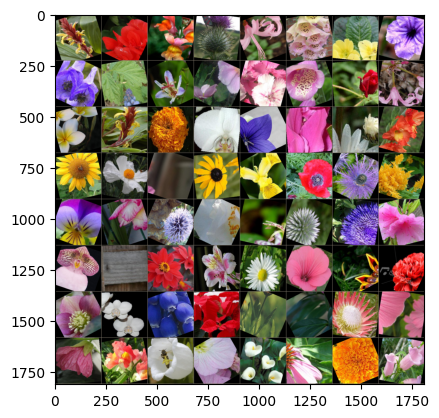

-cautleya spicata -geranium -snapdragon -spear thistle -cape flower -foxglove -primula -mexican petunia -monkshood -grape hyacinth -toad lily -japanese anemone -sweet william -foxglove -rose  -cape flower -frangipani -cautleya spicata -marigold -moon orchid -balloon flower -cyclamen -oxeye daisy -sword lily -sunflower -tree poppy -bougainvillea -black-eyed susan -yellow iris -corn poppy -alpine sea holly -prince of wales feathers -wild pansy -sword lily -globe thistle -camellia -toad lily -globe thistle -artichoke -azalea -hard-leaved pocket orchid -clematis -bishop of llandaff -peruvian lily -oxeye daisy -tree mallow -gazania -carnation -lenten rose -moon orchid -grape hyacinth -poinsettia -english marigold -camellia -king protea -tree mallow -mallow -snapdragon -canterbury bells -pink primrose -giant white arum lily -purple coneflower -marigold -canterbury bells


In [15]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'-{classes[str(int(labels[j]))]:5s}' for j in range(batch_size)))

#### hyperparams

lr=0.001, momentum=0.9, weight_decay=0.001
200 epochs
[Epoch 200] Loss: 1.284
Accuracy: 38.039% | Validation Loss: 3.231
Accuracy: 31.631% | Correct: 1945
Training time: 2663.247 seconds

lr=0.001, momentum=0.9, weight_decay=0.005
200 epochs
[Epoch 200] Loss: 1.274
Accuracy: 37.745% | Validation Loss: 3.071
Accuracy: 32.867% | Correct: 2021
Training time: 2887.83925 seconds

lr=0.001, momentum=0.9, weight_decay=0.01
200 epochs
[Epoch 182] Loss: 1.505
Accuracy: 39.314% | Validation Loss: 2.856
Accuracy: 33.778% | Correct: 2077
Training time: 2963.833 seconds

lr=0.001, momentum=0.9, weight_decay=0.02
200 epochs
[Epoch 200] Loss: 1.444
Accuracy: 35.980% | Validation Loss: 3.116
Accuracy: 31.013% | Correct: 1907
Training time: 3298.298 seconds

lr=0.005, momentum=0.9, weight_decay=0.01
200 epochs
[Epoch 200] Loss: 1.618
Accuracy: 32.353% | Validation Loss: 3.211
Accuracy: 27.923% | Correct: 1717
Training time: 3193.9565 seconds

lr=0.0005, momentum=0.9, weight_decay=0.01
[Epoch 200] Loss: 3.611
Accuracy: 15.392% | Validation Loss: 3.682
Accuracy: 13.856% | Correct: 852
Training time: 3285.9325 seconds


lr=0.001, momentum=0.9, weight_decay=0.001
400 epochs
[Epoch 400] Loss: 0.651
Accuracy: 40.000% | Validation Loss: 3.811
Accuracy: 34.412% | Correct: 2116
Training time: 5742.630 seconds

lr=0.001, momentum=0.9, weight_decay=0.001
1000 epochs
[Epoch 1000] Loss: 0.273
Accuracy: 40.196% | Validation Loss: 4.742
Accuracy: 35.697% | Correct: 2195
Training time: 15472.661 seconds

Final Model
lr=0.001, momentum=0.9, weight_decay=0.01
1000 epochs
[Epoch 1000] Loss: 0.428
Accuracy: 39.804% | Validation Loss: 3.724
Accuracy: 35.843% | Correct: 2204
Training time: 15541.81 seconds

#### NN Model

Conv1, bn1, reLu, pool, dropout, Conv2, bn2, reLu, pool, dropout, Conv3, bn3, reLu, pool, dropout, Flatten, fc1, ReLU, dropout, fc2, ReLU, dropout, fc3 - output


In [16]:
class ImageClassifier(nn.Module):
      def __init__(self, device):
            super(ImageClassifier, self).__init__()
            n1, n2 = 256, 192
            c1, c2, self.c3 = 6, 16, 32
            self.H, self.W = 224, 224
            kernel_size, kernel_size2, kernel_size3 = 7, 5, 3

            self.pool = nn.MaxPool2d(2, 2)

            self.conv1 = nn.Conv2d(3, c1, kernel_size=kernel_size, device=device)  
            self.conv2 = nn.Conv2d(c1, c2, kernel_size=kernel_size2, device=device)
            self.conv3 = nn.Conv2d(c2, self.c3, kernel_size=kernel_size3, device=device)

            self.bn1 = nn.BatchNorm2d(c1, device=device)
            self.bn2 = nn.BatchNorm2d(c2, device=device)
            self.bn3 = nn.BatchNorm2d(self.c3, device=device)

            self.n_features = self._initialize_fc_layers(device)
            
            self.fc1 = nn.Linear(self.n_features, n1, device=device)
            self.fc2 = nn.Linear(n1, n2, device=device)
            self.fc3 = nn.Linear(n2, len(classes), device=device)

            self.conv_dropout = nn.Dropout2d(0.3) # Dropout for conv layers
            self.fc_dropout = nn.Dropout(0.5)  # Dropout for fully connected layers

            # Initialize weights
            nn.init.xavier_uniform_(self.conv1.weight)
            nn.init.xavier_uniform_(self.conv2.weight)
            nn.init.xavier_uniform_(self.conv3.weight)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
            
      def _initialize_fc_layers(self, device):
        # Dummy forward pass to compute the size of the flattened features
            with torch.no_grad():
                  x = torch.zeros(1, 3, self.H, self.W, device=device)
                  x = self.pool(F.relu(self.bn1(self.conv1(x))))
                  x = self.pool(F.relu(self.bn2(self.conv2(x))))
                  x = self.pool(F.relu(self.bn3(self.conv3(x))))
                  return self.c3 * len(x[0][0]) ** 2

      def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.conv_dropout(x)

            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.conv_dropout(x)

            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.conv_dropout(x)
            
            x = x.view(-1, self.n_features)

            x = F.relu(self.fc1(x))
            x = self.fc_dropout(x)
            
            x = F.relu(self.fc2(x))
            x = self.fc_dropout(x)

            x = self.fc3(x)
            
            return x
      
      def validate(self, val_loader, criterion, device):
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                  for data in val_loader:
                        inputs, labels = data[0].to(device), data[1].to(device)
                        outputs = self(inputs)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            avg_val_loss = val_loss / len(val_loader)
            return avg_val_loss, accuracy


#### Define save

In [17]:
def save_model(model):
    torch.save(model, "./flowers-102_model.pth")

#### Define device

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


#### Train the model

In [18]:
model = ImageClassifier(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

epochs = 1000
high_acc = -1

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_val_loss, accuracy = model.validate(val_loader, criterion, device)

    if accuracy > high_acc:
        high_acc = accuracy
        save_model(model) # saves the model with the highest validation accuracy
        print("Saved current model")
    
    print('[Epoch %d] Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    print('Accuracy: %.3f%% | Validation Loss: %.3f' % (accuracy, avg_val_loss))
    print("")


end.record()
torch.cuda.synchronize()

print("Finished Training | Training time:", start.elapsed_time(end) / 1000, "seconds")

Saved current model
[Epoch 1] Loss: 5.298
Accuracy: 0.882% | Validation Loss: 4.628

[Epoch 2] Loss: 4.615
Accuracy: 0.686% | Validation Loss: 4.618

Saved current model
[Epoch 3] Loss: 4.599
Accuracy: 1.765% | Validation Loss: 4.600

[Epoch 4] Loss: 4.586
Accuracy: 1.765% | Validation Loss: 4.575

Saved current model
[Epoch 5] Loss: 4.548
Accuracy: 2.255% | Validation Loss: 4.546

Saved current model
[Epoch 6] Loss: 4.511
Accuracy: 3.333% | Validation Loss: 4.498

Saved current model
[Epoch 7] Loss: 4.468
Accuracy: 3.725% | Validation Loss: 4.442

Saved current model
[Epoch 8] Loss: 4.425
Accuracy: 4.608% | Validation Loss: 4.379

Saved current model
[Epoch 9] Loss: 4.361
Accuracy: 5.490% | Validation Loss: 4.316

[Epoch 10] Loss: 4.309
Accuracy: 5.000% | Validation Loss: 4.264

Saved current model
[Epoch 11] Loss: 4.262
Accuracy: 6.765% | Validation Loss: 4.202

Saved current model
[Epoch 12] Loss: 4.194
Accuracy: 7.353% | Validation Loss: 4.130

Saved current model
[Epoch 13] Loss: 

#### Define evaluate

In [22]:
def evaluate(model, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("Accuracy: %.3f%% | Correct: %.0f" % (accuracy, correct))

#### Test on test data

In [20]:
evaluate(model, device)

Accuracy: 35.843% | Correct: 2204


#### Define Manual save

In [21]:
def manual_save_model(model):
    torch.save(model, "./flowers-102_model_manual_save.pth")

#### Save the model as a manual save

In [25]:
manual_save_model(model)

#### Define load model

In [19]:
def load_model(device, path):
    model = ImageClassifier(device)
    model = torch.load(path)
    model.eval()
    return model

#### Load the best validation accuracy model

In [23]:
model_loaded = load_model(device, "./flowers-102_model.pth") # flowers-102_model is the model with the highest validation accuracy during training

#### Load the manual_save model

In [20]:
model_loaded = load_model(device, "./flowers-102_model_manual_save.pth") # flowers-102_model_manual_save is the model that has been manualy saved

#### Test loaded model on test data

In [23]:
evaluate(model_loaded, device)

Accuracy: 35.843% | Correct: 2204


#### Save loaded_model as manual_save

In [27]:
save_model(model_loaded)

#### Test loaded model on 1 batch of test data

In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
labels += 1

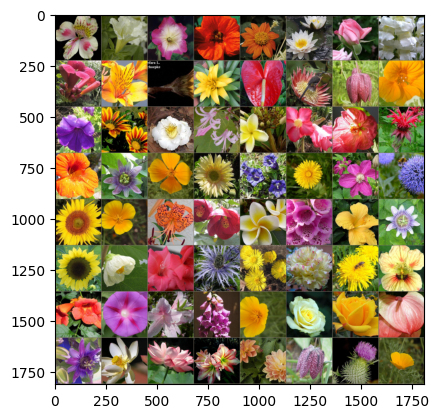

-peruvian lily -petunia -petunia -watercress -orange dahlia -water lily -rose  -snapdragon -trumpet creeper -peruvian lily -colt's foot -bromelia -anthurium -king protea -fritillary -watercress -petunia -gazania -camellia -cape flower -frangipani -desert-rose -mallow -bee balm -watercress -passion flower -californian poppy -barbeton daisy -stemless gentian -common dandelion -clematis -globe thistle -sunflower -californian poppy -tiger lily -mallow -frangipani -foxglove -hibiscus -passion flower -sunflower -mallow -sword lily -alpine sea holly -colt's foot -carnation -common dandelion -watercress -trumpet creeper -morning glory -azalea -foxglove -californian poppy -rose  -rose  -anthurium -passion flower -lotus lotus -lotus lotus -hippeastrum -pink-yellow dahlia -fritillary -spear thistle -californian poppy


In [25]:
imshow(torchvision.utils.make_grid(torch.Tensor.cpu(images)))
print(' '.join(f'-{classes[str(int(labels[j]))]:5s}' for j in range(batch_size)))

In [26]:
outputs = model_loaded(images)
_, predicted = torch.max(outputs, 1)
predicted += 1

In [27]:
print(' '.join(f'-{classes[str(int(predicted[j]))]:5s}' for j in range(batch_size)))

-mallow -petunia -columbine -corn poppy -orange dahlia -tree poppy -canterbury bells -canterbury bells -bee balm -marigold -hard-leaved pocket orchid -watercress -camellia -tiger lily -bearded iris -english marigold -wild pansy -gazania -windflower -magnolia -frangipani -poinsettia -peruvian lily -bee balm -marigold -mexican petunia -english marigold -frangipani -stemless gentian -common dandelion -garden phlox -love in the mist -sunflower -californian poppy -tiger lily -lenten rose -frangipani -foxglove -yellow iris -toad lily -sunflower -petunia -poinsettia -alpine sea holly -colt's foot -moon orchid -common dandelion -wallflower -bromelia -morning glory -clematis -foxglove -californian poppy -daffodil -globe-flower -anthurium -passion flower -windflower -peruvian lily -anthurium -pink-yellow dahlia -fritillary -spear thistle -californian poppy


In [28]:
correct = 0
for i in range(len(predicted)):
  if predicted[i] == labels[i]:
    correct += 1

print("Accuracy: %.3f%% | %.0f" % ((correct / len(predicted)) * 100, correct))

Accuracy: 39.062% | 25


#### Predict class of images presented by user (images in to_predict directory)

In [31]:
def predict(device, model, directory, paths):
    model.eval()  # Set the model to evaluation mode
    images = [PIL.Image.open(image_path) for image_path in paths]
    batch_size = len(images)
    images = (torch.stack([data_transforms['other'](image) for image in images])).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted += 1
    
    print(' '.join(f'{str(paths[j]).replace(directory, "")} - {classes[str(int(predicted[j]))]:5s}, ' for j in range(batch_size)))

In [32]:
directory = "./to_predict"
paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
predict(device, model_loaded, directory, paths)

\corn poppy.jpg - red ginger,  \oxeye daisy.jpg - oxeye daisy,  \pasion-flower2.jpg - passion flower,  \pasion_flower.jpg - passion flower,  \prince_wales_thing.jpg - foxglove,  \red-ginger-plants.jpg - red ginger,  \snapdragons-flowers.jpg - wallflower,  \Sweet-William.jpg - sweet william, 
